In [1]:
%matplotlib inline

In [2]:
import os, sys, time
from collections import OrderedDict

import matplotlib as mpl    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

from IPython.display import Image

mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.dpi'] = 72

import numpy as np
#from math import cos, sin, atan2, pi
from math import sqrt, log

import astropy
import astropy.io.fits as pyfits
import astropy.wcs as pywcs
from astropy.table import Table, join
from astropy.modeling import models

import drizzlepac
import photutils

import grizli
import grizli.model
import grizli.multifit
from grizli import utils, multifit, fitting
import grizli.fake_image
from grizli.pipeline import auto_script
from grizli import prep


print('\n Python version: ', sys.version)
print('\n Grizli version: ', grizli.__version__)
print('\n Astropy version: ', astropy.__version__)



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol

 Python version:  3.9.12 (main, Jun  1 2022, 11:38:51) 
[GCC 7.5.0]

 Grizli version:  1.5.1.dev126

 Astropy version:  5.1


sh: aws: command not found


## Path to my simulation directories
[top](#Table-of-Contents)

In [3]:
#os.chdir('../')
os.chdir('/home/gwalth/data/Roman/grizli/sims/')
#os.chdir('/local/RomanSims/grizli/sims/') # cygnusd
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)
#root = "hlss"        # multiple rolls
#root = "hlss_single"  # single roll
root = "hlss_single_v5"  # single roll

prefix = "hlss"
field = "field_0001"

HOME_PATH =  /home/gwalth/data/Roman/grizli/sims


In [5]:
import glob

os.chdir(os.path.join(HOME_PATH, root, 'Prep', field))

# before adding noise
direct_files = glob.glob('*direct.fits')
slitless_files = glob.glob('*slitless.fits')

direct_files.sort()
slitless_files.sort()

print(direct_files)
print(slitless_files)
print(len(direct_files))
print(len(slitless_files))
print(os.getcwd())

['Euclid_Roman_4deg2_field_0001_v5_direct.fits']
['Euclid_Roman_4deg2_field_0001_v5_slitless.fits']
1
1
/home/gwalth/data/Roman/grizli/sims/hlss_single_v5/Prep/field_0001


In [8]:
# newer
direct_files = glob.glob('*f158_flt.fits')
slitless_files = glob.glob('*gr_flt.fits')
# older versions
#direct_files = glob.glob('*direct_final.fits')
#slitless_files = glob.glob('*slitless_final.fits')

print(direct_files)
print(slitless_files)
print(len(direct_files))
print(len(slitless_files))
print(os.getcwd())

['hlss-001.0-f158_flt.fits']
['hlss-001.0-gr_flt.fits']
1
1
/home/gwalth/data/Roman/grizli/sims/hlss_single_v5/Prep/field_0001


In [9]:
direct = direct_files[0]
slitless = slitless_files[0]

['hlss-001.0-f158_flt.fits', 'hlss-001.0-gr_flt.fits']
-0.18916439 7.6237583
0.0069361324 0.0021271722 0.07381704
-0.09410017222166062 0.46670074224472047
-0.12865612 3.5143263
0.010964256 0.007880826 0.03430704
-0.05731229513883591 0.2458731716871263


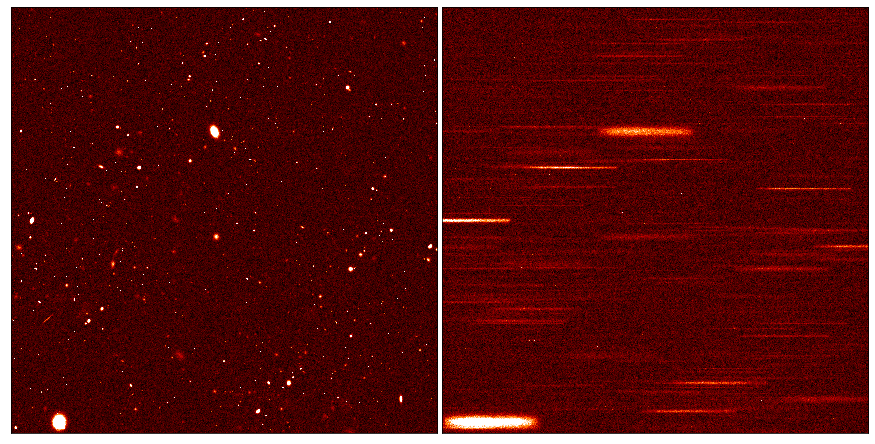

In [23]:
##########
# Images #
##########
from matplotlib import cm

ncols = 2

all = [direct, slitless]
print(all)

#N = len(all)
# not sure why this isn't working
#nrows = -(-N/ncols) # returns ceiling of division
#print(nrows)
nrows = 1

fig = plt.figure(figsize=(12,6))

for i,a in enumerate(all):
    pf = pyfits.open(a)
    image = pf['SCI'].data
    
    #image = np.log10(image)
    im_mean = np.nanmean(image)
    im_median = np.nanmedian(image)
    im_std = np.nanstd(image)
    im_min = np.nanmin(image)
    im_max = np.nanmax(image)
    
    #im_high = np.percentile(image,99.8)
    #im_low = np.percentile(image,0.2)
    
    im_high = np.percentile(image,99.7)
    im_low = np.percentile(image, 0.3)
    
    
    print(im_min,im_max)
    print(im_mean,im_median,im_std)
    print(im_low,im_high)
    
    # compute contrast
    #contrast = (im_max-im_min)/(im_max+im_min)
    #print(contrast)

    
    #cmap='magma' # looks good
    cmap='gist_heat'
    #cmap='YlOrRd_r' # meh
    #cmap="inferno" # looks good
    #cmap="plasma" # looks good
    #cmap="viridis" # looks good
    #cmap="cividis" # meh


    ax = fig.add_subplot(nrows,ncols,i+1)
    im = ax.imshow(image, interpolation='Nearest', 
              origin='lower', cmap=cmap,
              vmin=im_low, vmax=im_high)
    #ax.scatter(primer['X_IMAGE'], primer['Y_IMAGE'], s=100,
    #               edgecolor='green', facecolor='none', alpha=0.7)
    

    ax.set_xticks([])
    ax.set_yticks([])
    
    #fig.colorbar(im)


fig.tight_layout(pad=0.1)

plt.show()

['hlss-001.0-f158_flt.fits', 'hlss-001.0-gr_flt.fits']
0.0069361324 0.0021271722 0.07381704
0.9929314041137751
-0.10606972545385361
0.010964256 0.007880826 0.03430704
0.3215483367443247
-0.06526645392179489


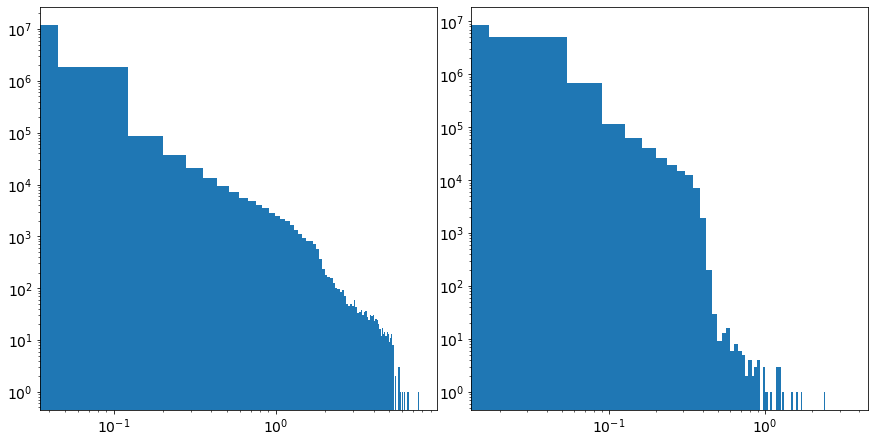

In [16]:
#############
# Histogram #
#############
from matplotlib import cm

ncols = 2

all = [direct,slitless]
print(all)

#N = len(all)
# not sure why this isn't working
#nrows = -(-N/ncols) # returns ceiling of division
#print(nrows)
nrows = 1

fig = plt.figure(figsize=(12,6))

for i,a in enumerate(all):
    pf = pyfits.open(a)
    image = pf['SCI'].data
    print(np.mean(image),np.median(image),np.std(image))
    

    ax = fig.add_subplot(nrows,ncols,i+1)
    
    X = image.flatten()
    
    print(np.percentile(X,99.9))
    print(np.percentile(X,0.1))
    ax.hist(X,bins=100)
    
    ax.set_xscale("log")
    ax.set_yscale("log")

fig.tight_layout(pad=0.1)

plt.show()